In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
!pip install tqdm
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Function to test independence of 2 random variables. 

Usage: 

`testStat, thresh = hsic_gam(X, Y, alph = 0.05)`

Independence test result
- If testStat < thresh, x and y are independent.
- If testStat > thresh, x and y are not independent.


In [ ]:
"""
python implementation of Hilbert Schmidt Independence Criterion
hsic_gam implements the HSIC test using a Gamma approximation
Python 2.7.12
Gretton, A., Fukumizu, K., Teo, C. H., Song, L., Scholkopf, B., 
& Smola, A. J. (2007). A kernel statistical test of independence. 
In Advances in neural information processing systems (pp. 585-592).
Shoubo (shoubo.sub AT gmail.com)
https://github.com/amber0309/HSIC
09/11/2016
Inputs:
X n by dim_x matrix
Y n by dim_y matrix
alph level of test
Outputs:
testStat test statistics
thresh test threshold for level alpha test
"""

from __future__ import division
import numpy as np
from scipy.stats import gamma

def rbf_dot(pattern1, pattern2, deg):
    size1 = pattern1.shape
    size2 = pattern2.shape
    G = np.sum(pattern1*pattern1, 1).reshape(size1[0],1)
    H = np.sum(pattern2*pattern2, 1).reshape(size2[0],1)
    Q = np.tile(G, (1, size2[0]))
    R = np.tile(H.T, (size1[0], 1))
    H = Q + R - 2* np.dot(pattern1, pattern2.T)
    H = np.exp(-H/2/(deg**2))
    return H


def hsic_gam(X, Y, alph = 0.5):
    """
    X, Y are numpy vectors with row - sample, col - dim
    alph is the significance level
    auto choose median to be the kernel width
    """
    n = X.shape[0]
    # ----- width of X -----
    Xmed = X
    G = np.sum(Xmed*Xmed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Xmed, Xmed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_x = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    # ----- width of X -----
    Ymed = Y
    G = np.sum(Ymed*Ymed, 1).reshape(n,1)
    Q = np.tile(G, (1, n) )
    R = np.tile(G.T, (n, 1) )
    dists = Q + R - 2* np.dot(Ymed, Ymed.T)
    dists = dists - np.tril(dists)
    dists = dists.reshape(n**2, 1)
    width_y = np.sqrt( 0.5 * np.median(dists[dists>0]) )
    # ----- -----
    bone = np.ones((n, 1), dtype = float)
    H = np.identity(n) - np.ones((n,n), dtype = float) / n
    K = rbf_dot(X, X, width_x)
    L = rbf_dot(Y, Y, width_y)
    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)
    testStat = np.sum(Kc.T * Lc) / n
    varHSIC = (Kc * Lc / 6)**2
    varHSIC = ( np.sum(varHSIC) - np.trace(varHSIC) ) / n / (n-1)
    varHSIC = varHSIC * 72 * (n-4) * (n-5) / n / (n-1) / (n-2) / (n-3)
    K = K - np.diag(np.diag(K))
    L = L - np.diag(np.diag(L)) 
    muX = np.dot(np.dot(bone.T, K), bone) / n / (n-1)
    muY = np.dot(np.dot(bone.T, L), bone) / n / (n-1)
    mHSIC = (1 + muX * muY - muX - muY) / n
    al = mHSIC**2 / varHSIC
    bet = varHSIC*n / mHSIC
    thresh = gamma.ppf(1-alph, al, scale=bet)[0][0]
    return (testStat, thresh)

# Linear model $Y=bX+\epsilon$

## Gaussian distribution

Generate data

In [ ]:
N = 1000
#x = np.random.normal(0, 1, size=N)
x = np.random.uniform(0, 1, size=N)
#x = np.random.laplace(loc=0.0, scale=1., size=N)
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)
y = x + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

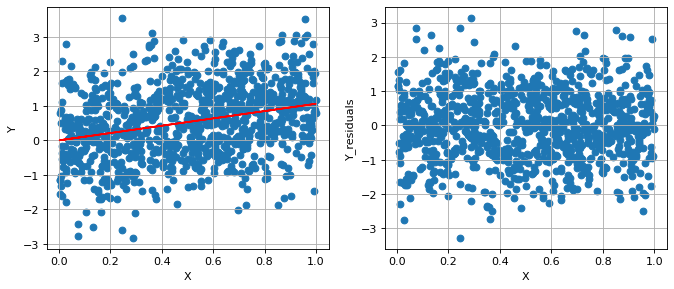

In [ ]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x.reshape(-1, 1),y)
y_pred = regressor.predict(x.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")

Test independence

In [ ]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.30940666989346033 0.6124384715048704
Independent: True


Regress $X$ on $Y$

Text(0, 0.5, 'X_residuals')

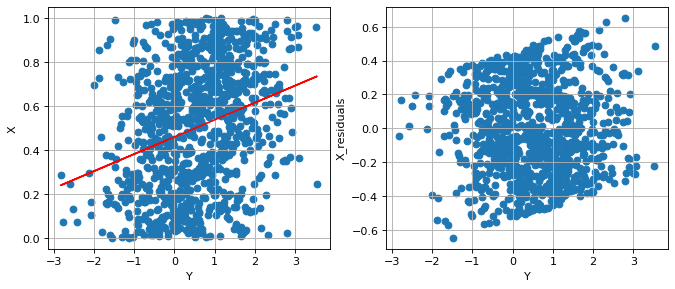

In [ ]:
# build regression model
regressor.fit(y.reshape(-1, 1),x)
x_pred = regressor.predict(y.reshape(-1, 1))

# plotting
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
plt.plot(y, x_pred, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")

Test independence

In [ ]:
testStat, thresh = hsic_gam(X=y.reshape(-1, 1), Y=x_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

1.699357911457443 0.6081483973139213
Independent: False


$\newcommand{\indep}{\perp \!\!\! \perp}$
 $(X,\varepsilon)  \not \indep $
In order to determine cause and effect from $X$ and $Y$, regression on both directions are applied.
1. regressing $Y$ on $X$: 
$Y = X + \varepsilon$
2. regressing $X$ on $Y$:
$X = Y + varepsilon$

Structure of the model in case (2) requires that predictor and noise would be independent, i.e., $Y \indep \varepsilon$, but we see from the plot above this condition doesn't hold, therefore model (2) is not valid and hence the direction is according to case (1): $X → Y$


## Exercise 1:
Try different distributions for $X$ and $\epsilon$ and fill the results in a table. What are your conclusions? Which cases are identifiable?

Note, you can use one type of distibution for $X$ and another type of distribution for $\epsilon$.

Distributions to use:
1. `np.random.normal`
2. `np.random.uniform`
3. `np.random.laplace`

## Example of non-linear model $Y=bX^3+\epsilon$

Generate data

In [ ]:
N = 1000
x = np.sort(np.random.normal(0, 1, size=N)) # sort X
#x = np.sort(np.random.uniform(-3, 3, size=N))
#x = np.sort(np.random.laplace(loc=0.0, scale=1., size=N))
eps = np.random.normal(0, 1, size=N)
#eps = np.random.uniform(-0.5, 0.5, size=N)
#eps = np.random.laplace(loc=0.0, scale=0.5, size=N)

y = x**3 + eps

Regress $Y$ on $X$

Text(0, 0.5, 'Y_residuals')

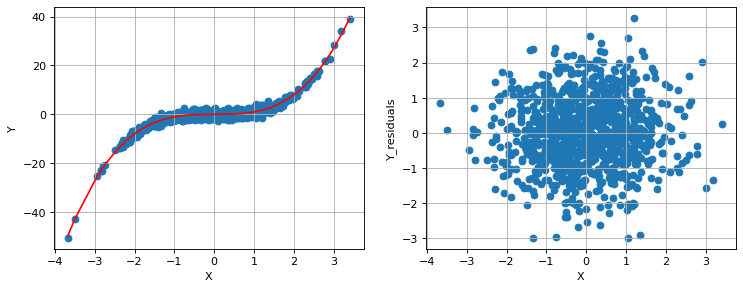

In [ ]:
# build regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
# transform X to use LinearRegression model
x_transform = x**3
regressor.fit(x_transform.reshape(-1, 1),y)
y_pred = regressor.predict(x_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=x, y=y)
#plt.scatter(x=x, y=y_pred, color="red")
plt.plot(x, y_pred, color="red")
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")

# calculate the residuals and plot them
y_residuals = y_pred - y
plt.subplot(122)
plt.scatter(x=x, y=y_residuals)
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y_residuals")
#plt.xlabel("Y")
#plt.ylabel("X_residuals")

Test independence

In [ ]:
testStat, thresh = hsic_gam(X=x.reshape(-1, 1), Y=y_residuals.reshape(-1, 1), alph = 0.05)
print(testStat, thresh)
print("Independent: {}".format(testStat < thresh))

0.26426530091321343 0.585606466190895
Independent: True


Text(0, 0.5, 'X_residuals')

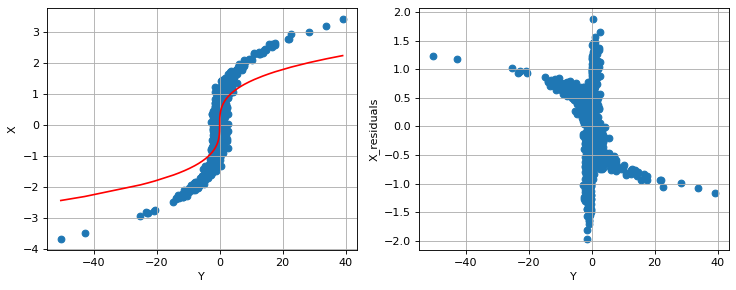

In [ ]:
# build regression model
y_transform = np.cbrt(y)
regressor.fit(y_transform.reshape(-1, 1),x)
x_pred = regressor.predict(y_transform.reshape(-1, 1))

# plotting
figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(x=y, y=x)
# sort by y 
y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
y_sorted = list(y_sorted)
x_pred_sorted = list(x_pred_sorted)

plt.plot(y_sorted, x_pred_sorted, color="red")
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X")

# calculate the residuals and plot them
x_residuals = x_pred - x
plt.subplot(122)
plt.scatter(x=y, y=x_residuals)
plt.grid(True)
plt.xlabel("Y")
plt.ylabel("X_residuals")
#plt.xlabel("X")
#plt.ylabel("Y_residuals")

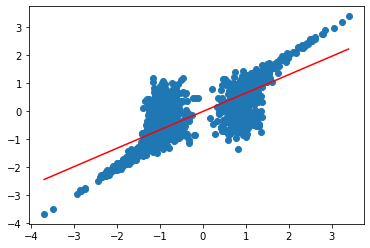

In [ ]:
plt.scatter(y_transform, x)
plt.plot(y_transform, x_pred, color="red")

## Exercise 2

1. Try different distributions for $X$ and $\epsilon$ as in the previous assignment. Is there any case when we cannot identify causal direction?

## Exercise 3

1. Perform similar tests for the model  $Y=f(X)+\epsilon$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
Adjust the variation of $X$ and $\epsilon$ if required.
2. For varying values of variance ranging from $var(X) / var(\epsilon) = 0.01$ to $var(X) / var(\epsilon) = 100$, estimate the accuracy of direction identification as a fraction of correct identifications in 30 independent runs. Plot the results. For which ranges we observe identifiability?

### MY CODE

In [ ]:
## 
def regress(x_mean, x_var, eps_mean, eps_var, size, x_dist, eps_dist, func="l", regressor=None):
    x = x_dist(x_mean, x_var, size=size)
    eps = eps_dist(eps_mean, eps_var, size=size)
    x_transformed = x.copy()
    # cubic function
    if func == "c":
        x_transformed = x**3
    # quadratic function
    elif func == "q":
        x_transformed = x**2
    # sinus functions    
    elif func == "s":
        x_transformed == np.sin(x)
    # regress on either x (in linear case, as x remains intact), or if nonlinear on transformed x

    y = x_transformed + eps
    regressor = LinearRegression()
    regressor.fit(x_transformed.reshape(-1, 1),y)
    y_pred = regressor.predict(x_transformed.reshape(-1, 1))

    y_transformed = y.copy()
    # cubic function
    if func == "c":
        y_transformed = y**3
    # quadratic function
    elif func == "q":
        y_transformed = y**2
    # sinus functions    
    elif func == "s":
        y_transformed == np.sin(y)

    regressor2 = LinearRegression()
    regressor2.fit(y_transformed.reshape(-1, 1), x)
    x_pred = regressor2.predict(y_transformed.reshape(-1, 1))
    return x, x_transformed, eps, y, y_transformed, y_pred, x_pred

In [ ]:
#def regress_construct():
# construct a dictionary after regressing Y on X.
# Keys contain name of the distribution used, Items include X,Y, epsilon
# For each key applies the regress function defined before
mean = 0
var = 1
i=1
size = (1000, 1)
regressor=None
normal = np.random.normal
uniform = np.random.uniform
laplace = np.random.laplace

regress_dict = {
    "GAU": regress(mean, var, mean, var*i, size, normal, normal, func="l", regressor=regressor),
    "UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="l", regressor=regressor),
    "LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="l", regressor=regressor),
    "CUBIC_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="c", regressor=regressor),
    "CUBIC_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="c", regressor=regressor),
    "CUBIC_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="c", regressor=regressor),
    "QUAD_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="q", regressor=regressor),
    "QUAD_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="q", regressor=regressor),
    "QUAD_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="q", regressor=regressor),
    "SIN_GAU": regress(mean, var, mean, var*i, size, normal, normal, func="s", regressor=regressor),
    "SIN_UNI": regress(mean - var, mean + var, mean - var*i, mean + var*i, size, uniform, uniform, func="s", regressor=regressor),
    "SIN_LAP": regress(mean, var, mean, var*i, size, laplace, laplace, func="s", regressor=regressor),

    "GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="l", regressor=regressor),
    "GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="l", regressor=regressor),
    "CUBIC_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="c", regressor=regressor),
    "CUBIC_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="c", regressor=regressor),
    "QUAD_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="q", regressor=regressor),
    "QUAD_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="q", regressor=regressor),
    "SIN_GAUxUNI": regress(mean, var, mean - var*i, mean + var*i, size, normal, uniform, func="s", regressor=regressor),
    "SIN_GAUxLAP": regress(mean, var, mean, var*i, size, normal, laplace, func="s", regressor=regressor),


    "UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="l", regressor=regressor),
    "UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="l", regressor=regressor),
    "CUBIC_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="c", regressor=regressor),
    "CUBIC_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="c", regressor=regressor),
    "QUAD_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="q", regressor=regressor),
    "QUAD_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="q", regressor=regressor),
    "SIN_UNIxGAU": regress(mean - var, mean + var, mean, var*i, size, uniform, normal, func="s", regressor=regressor),
    "SIN_UNIxLAP": regress(mean - var, mean + var, mean, var*i, size, uniform, laplace, func="s", regressor=regressor),


    "LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="l", regressor=regressor),
    "LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="l", regressor=regressor),
    "CUBIC_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="c", regressor=regressor),
    "CUBIC_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="c", regressor=regressor),
    "QUAD_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="q", regressor=regressor),
    "QUAD_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="q", regressor=regressor),
    "SIN_LAPxGAU": regress(mean, var, mean, var*i, size, laplace, normal, func="s", regressor=regressor),
    "SIN_LAPxUNI": regress(mean, var, mean - var*i, mean + var*i, size, laplace, uniform, func="s", regressor=regressor)
}


In [ ]:
len(regress_dict['GAU'])

7

In [ ]:
dists = list(regress_dict.keys())
dists[:10]

['GAU',
 'UNI',
 'LAP',
 'CUBIC_GAU',
 'CUBIC_UNI',
 'CUBIC_LAP',
 'QUAD_GAU',
 'QUAD_UNI',
 'QUAD_LAP',
 'SIN_GAU']

In [ ]:
def plotter(dist):
    print(f"Case: (X,Epsilon) ~ {dist}")
    if dist.startswith("CUBIC"):
      print("function: Cubic")
    if dist.startswith("QUAD"):
      print("function: Quadratic")  
    if dist.startswith("SIN"):
      print("function: Sinus")    
    else:
      print("function: Linear")
    x, x_transformed, eps, y, y_transformed, y_pred, x_pred = regress_dict[dist] 
    
    # plotting
    figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.scatter(x=x, y=y)
    #plt.scatter(x=x, y=y_pred, color="red")
    plt.plot(x, y_pred, color="red")
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")

    # calculate the residuals and plot them
    y_residuals = y_pred - y
    plt.subplot(122)
    plt.scatter(x=x, y=y_residuals)
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y_residuals")
    #plt.xlabel("Y")
    #plt.ylabel("X_residuals")

    
    # plotting
    figure(num=None, figsize=(11, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.scatter(x=y, y=x)
    # sort by y 
    y_sorted, x_pred_sorted = zip(*sorted(zip(y, x_pred)))
    y_sorted = list(y_sorted)
    x_pred_sorted = list(x_pred_sorted)

    plt.plot(y_sorted, x_pred_sorted, color="red")
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X")

    # calculate the residuals and plot them
    x_residuals = x_pred - x
    plt.subplot(122)
    plt.scatter(x=y, y=x_residuals)
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X_residuals")
    plt.show()
    print("\n\n\n")
    #plt.xlabel("X")
    #plt.ylabel("Y_residuals")





Case: (X,Epsilon) ~ GAU
function: Linear


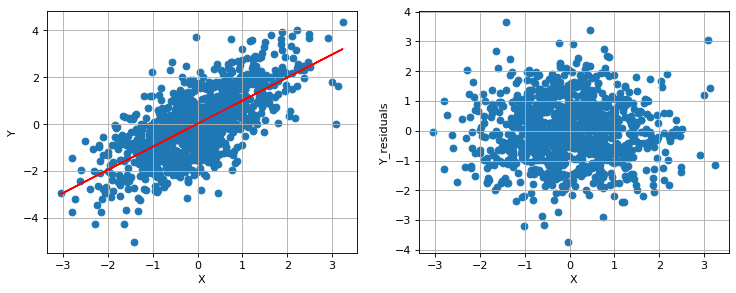

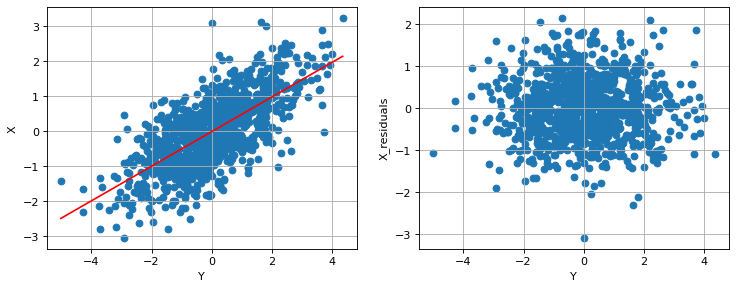





Case: (X,Epsilon) ~ UNI
function: Linear


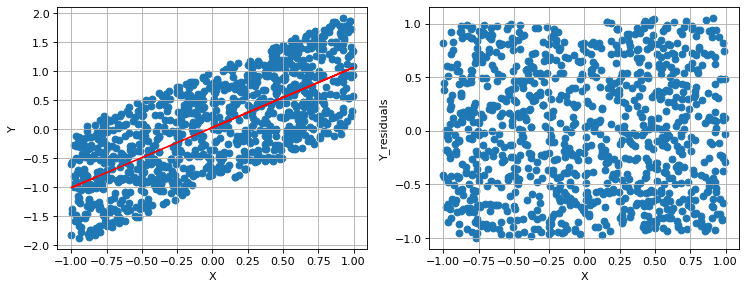

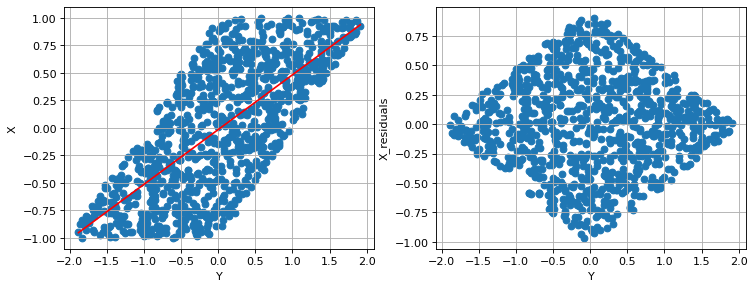





Case: (X,Epsilon) ~ LAP
function: Linear


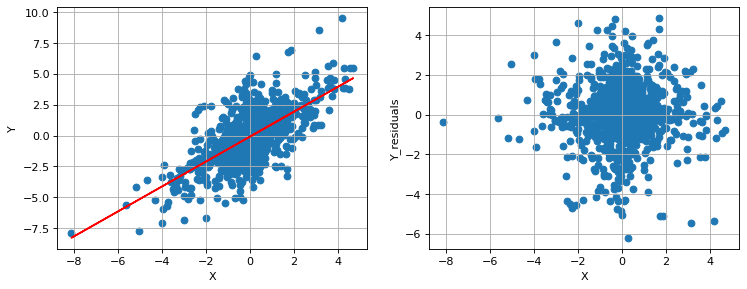

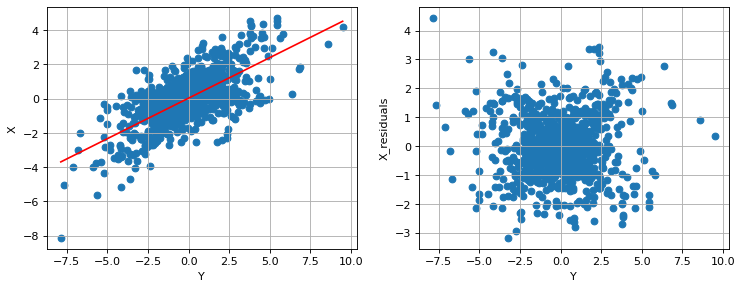





Case: (X,Epsilon) ~ CUBIC_GAU
function: Cubic
function: Linear


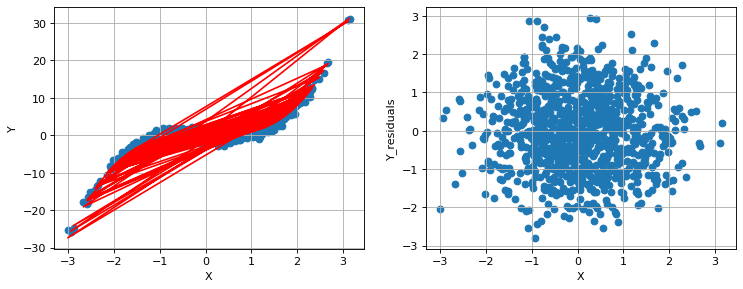

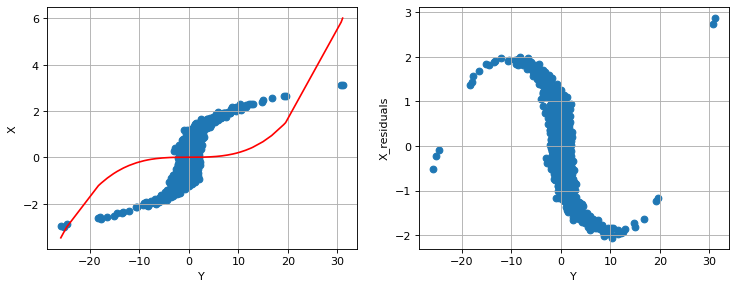





Case: (X,Epsilon) ~ CUBIC_UNI
function: Cubic
function: Linear


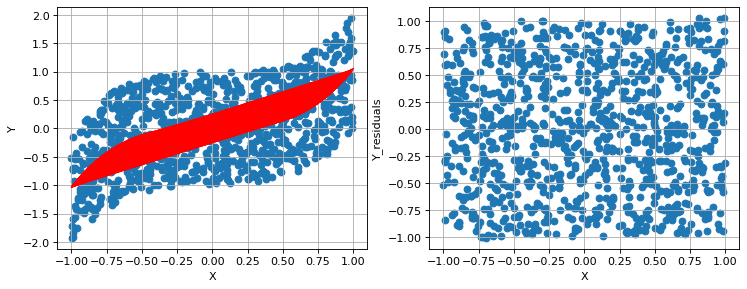

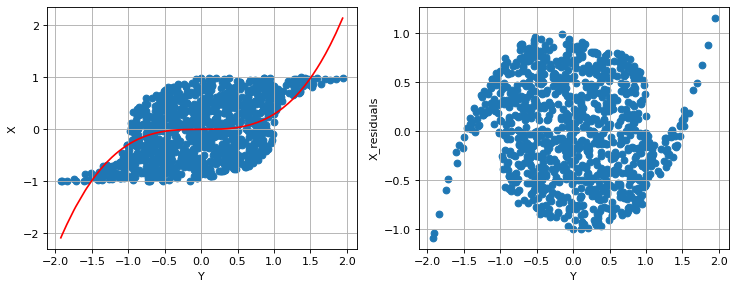





Case: (X,Epsilon) ~ CUBIC_LAP
function: Cubic
function: Linear


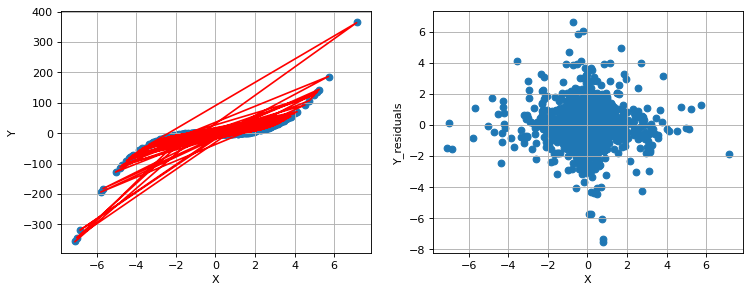

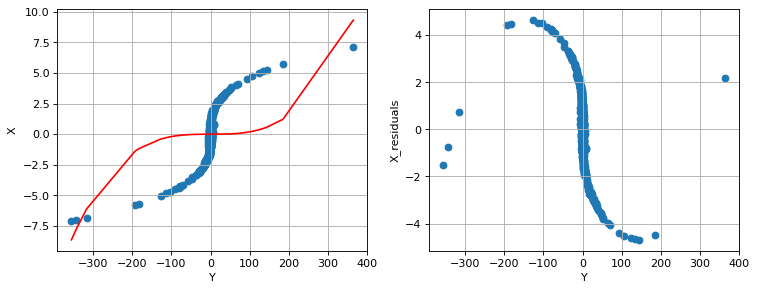





Case: (X,Epsilon) ~ QUAD_GAU
function: Quadratic
function: Linear


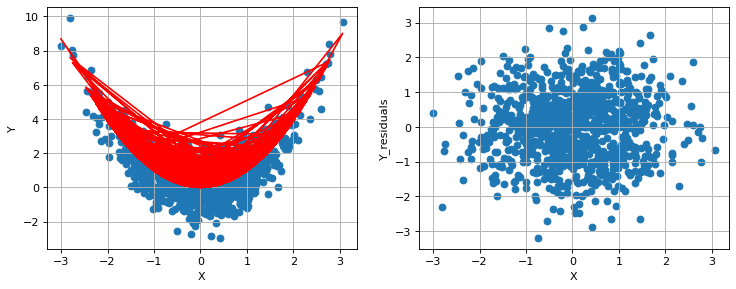

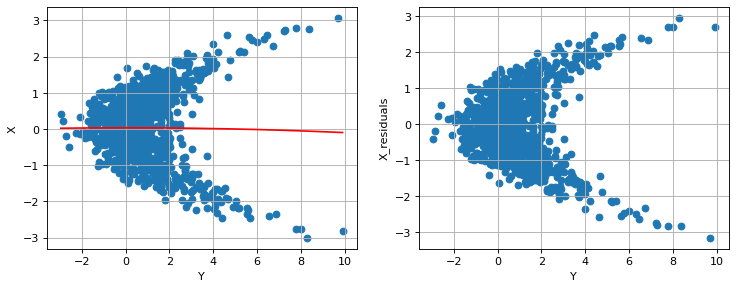





Case: (X,Epsilon) ~ QUAD_UNI
function: Quadratic
function: Linear


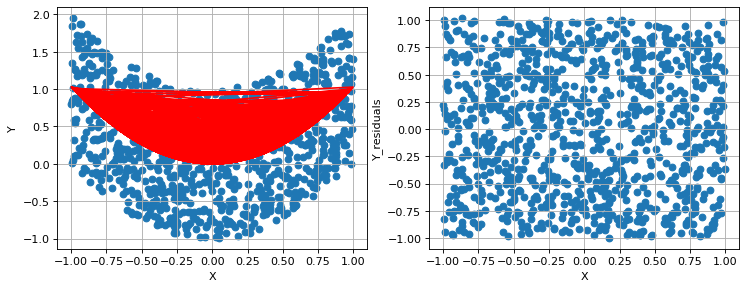

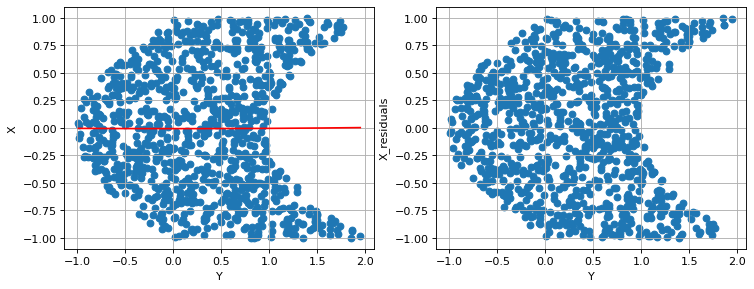





Case: (X,Epsilon) ~ QUAD_LAP
function: Quadratic
function: Linear


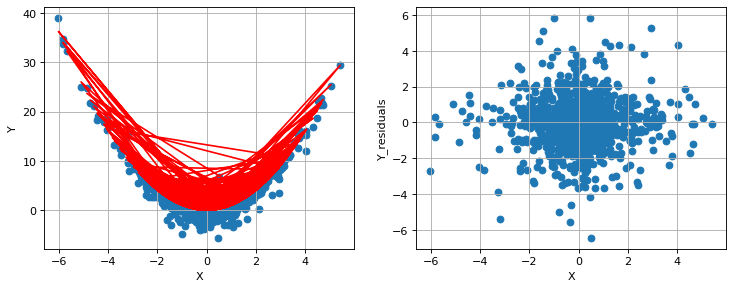

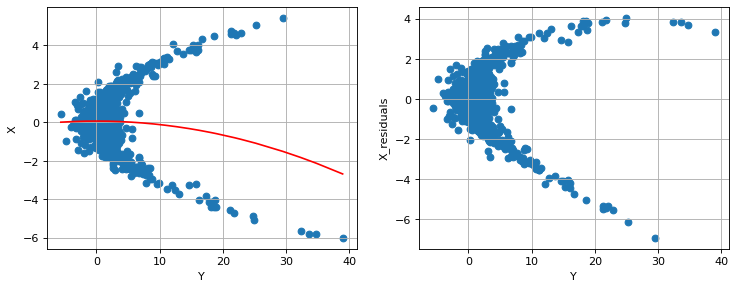





Case: (X,Epsilon) ~ SIN_GAU
function: Sinus


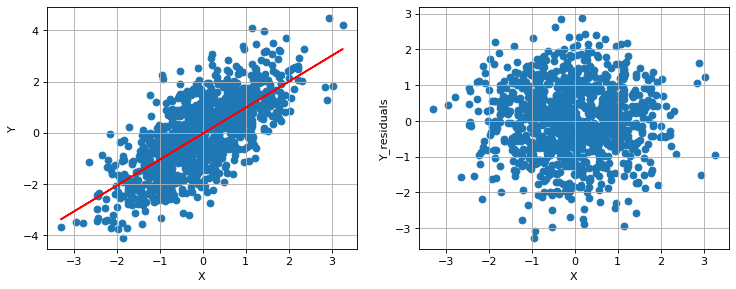

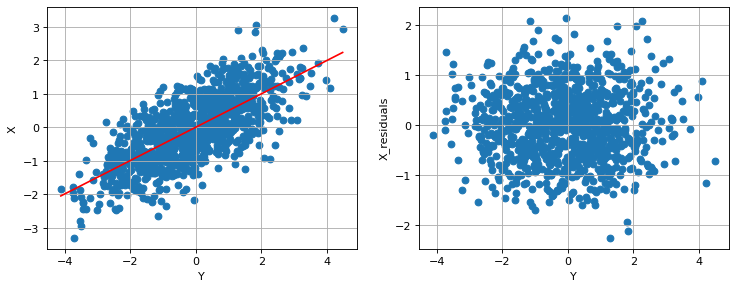





Case: (X,Epsilon) ~ SIN_UNI
function: Sinus


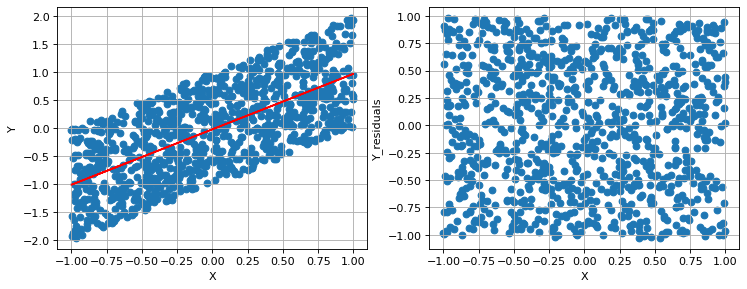

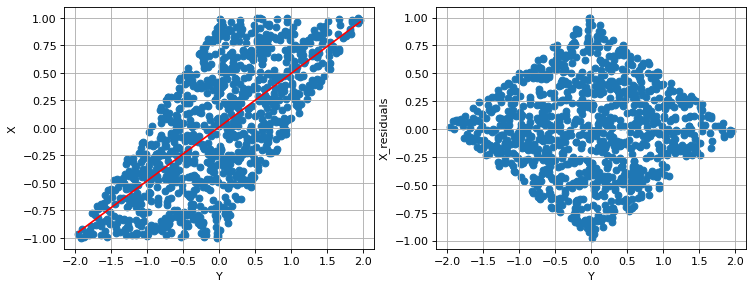





Case: (X,Epsilon) ~ SIN_LAP
function: Sinus


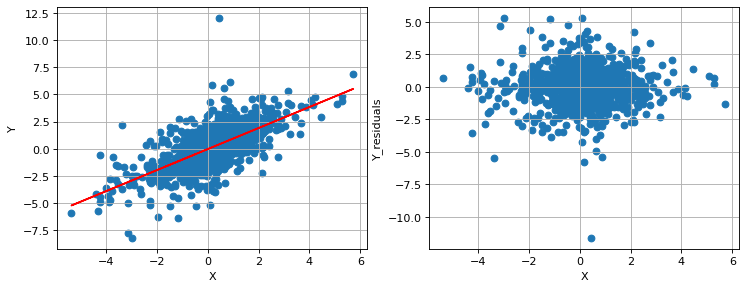

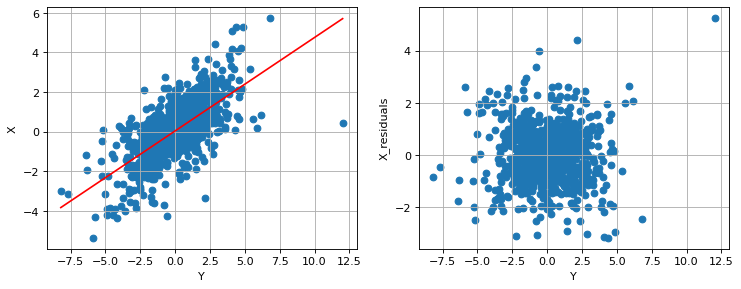





Case: (X,Epsilon) ~ GAUxUNI
function: Linear


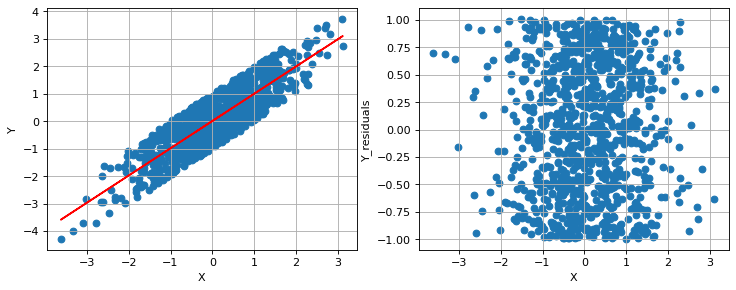

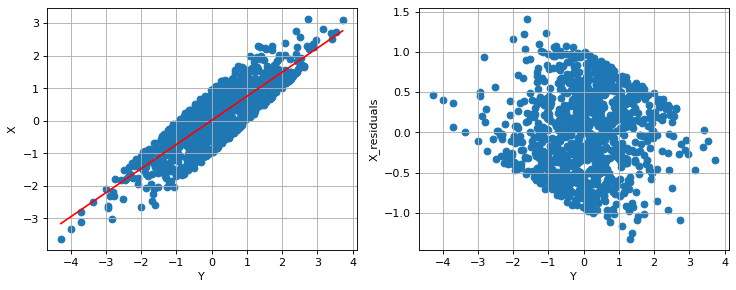





Case: (X,Epsilon) ~ GAUxLAP
function: Linear


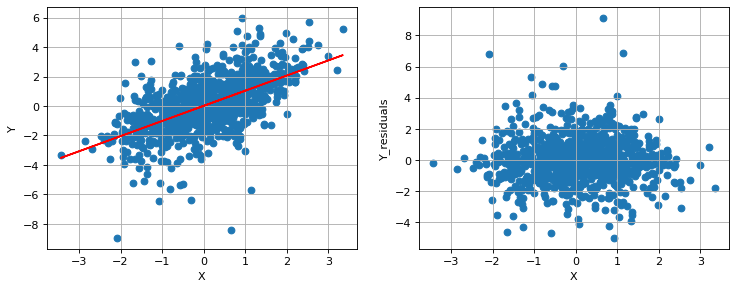

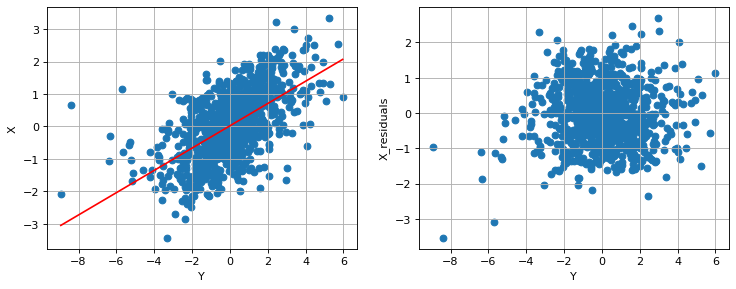





Case: (X,Epsilon) ~ CUBIC_GAUxUNI
function: Cubic
function: Linear


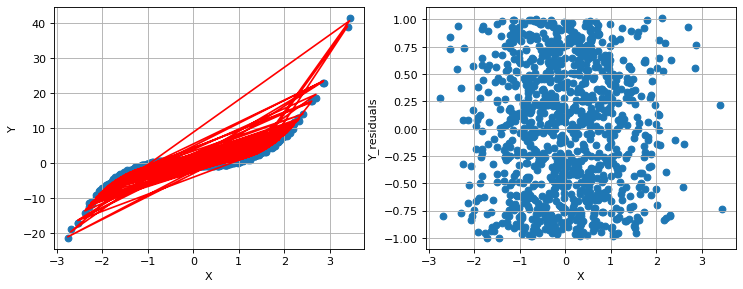

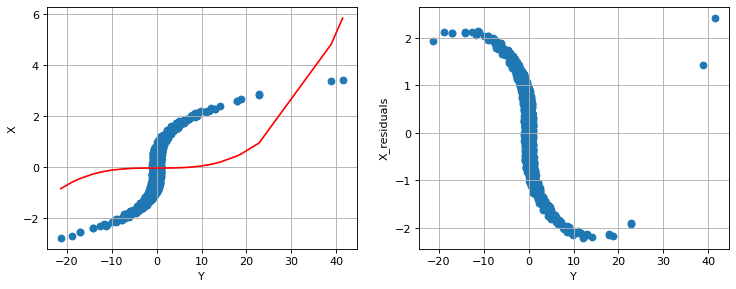





Case: (X,Epsilon) ~ CUBIC_GAUxLAP
function: Cubic
function: Linear


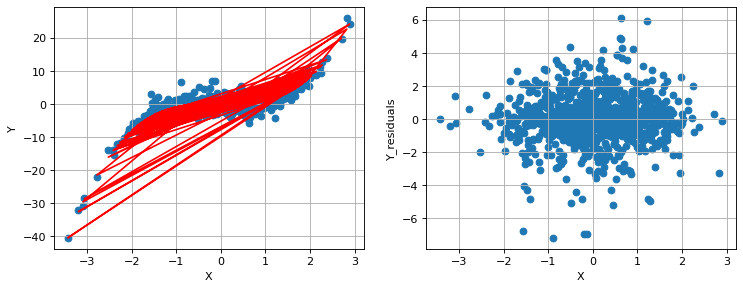

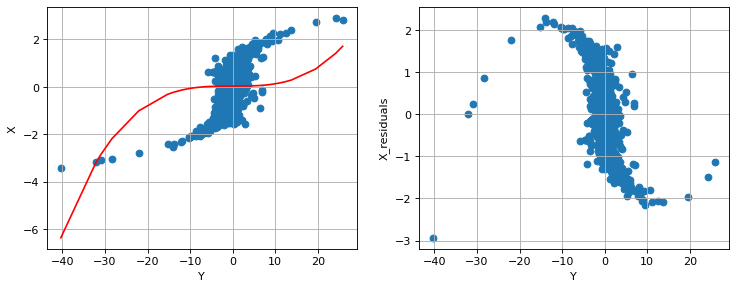





Case: (X,Epsilon) ~ QUAD_GAUxUNI
function: Quadratic
function: Linear


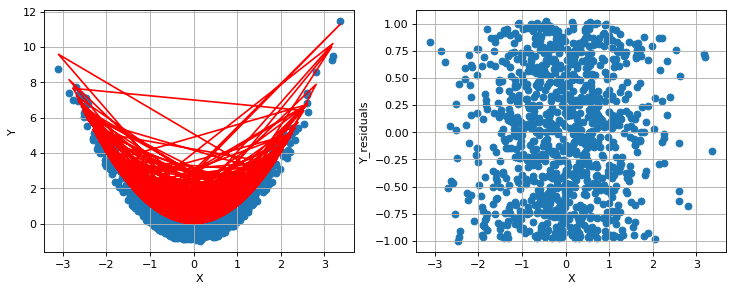

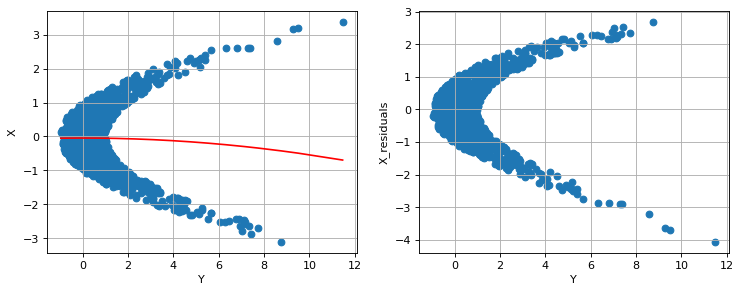





Case: (X,Epsilon) ~ QUAD_GAUxLAP
function: Quadratic
function: Linear


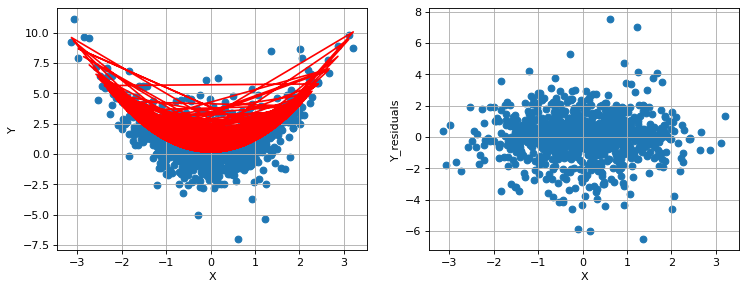

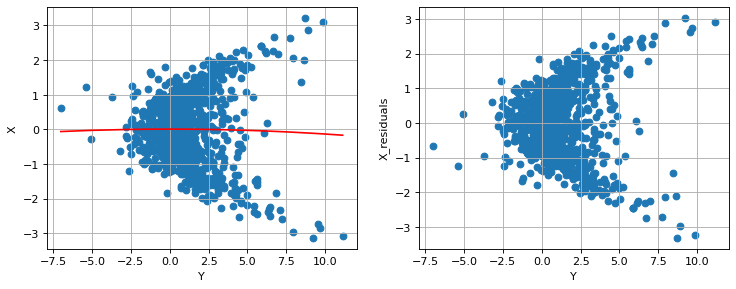





Case: (X,Epsilon) ~ SIN_GAUxUNI
function: Sinus


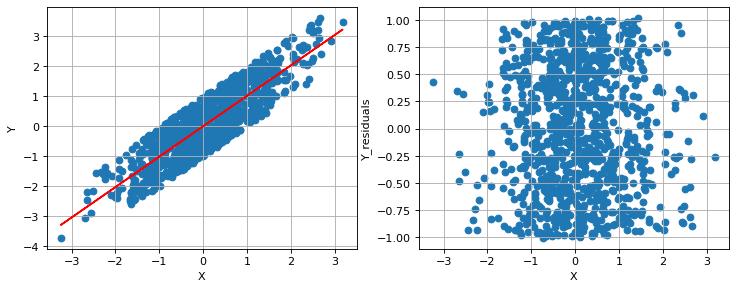

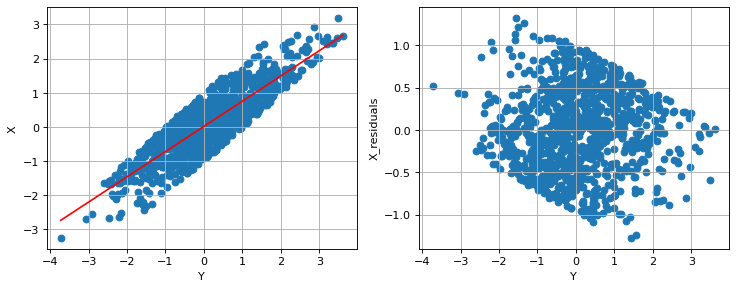





Case: (X,Epsilon) ~ SIN_GAUxLAP
function: Sinus


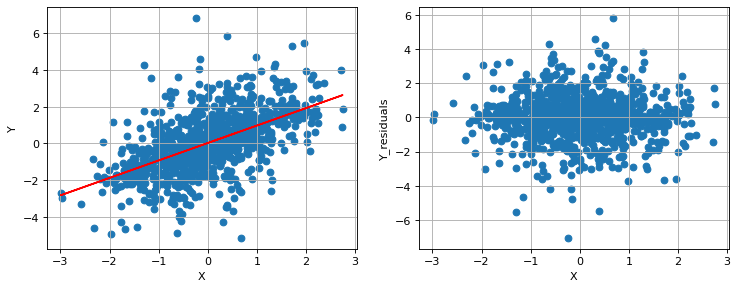

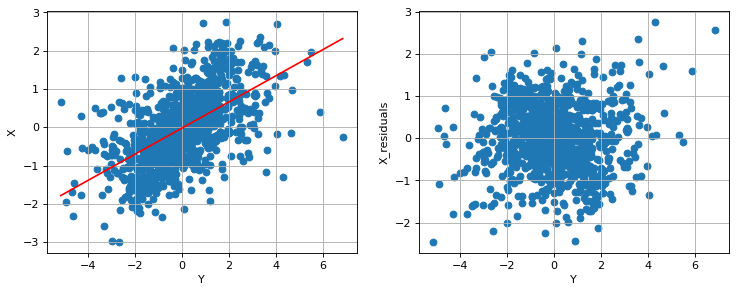





Case: (X,Epsilon) ~ UNIxGAU
function: Linear


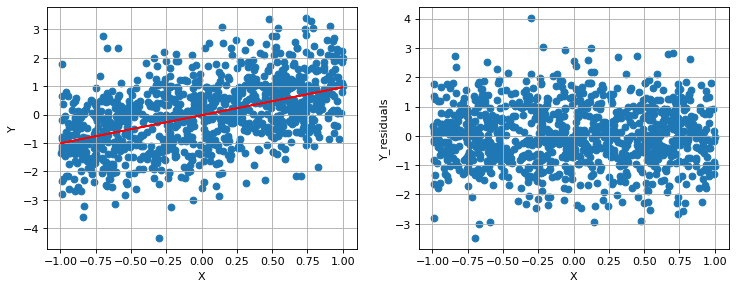

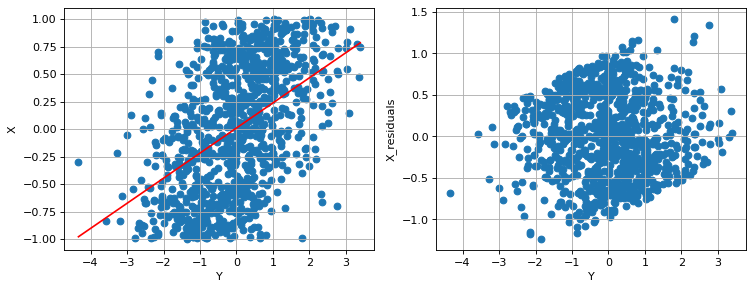





Case: (X,Epsilon) ~ UNIxLAP
function: Linear


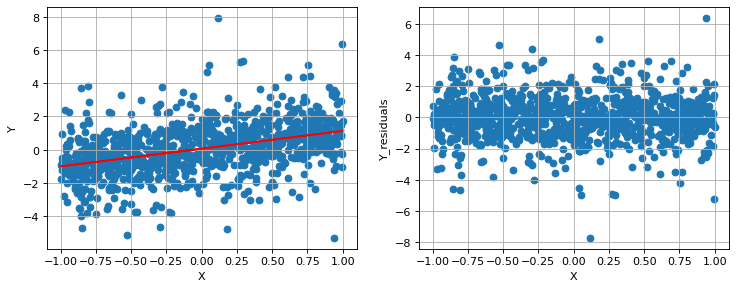

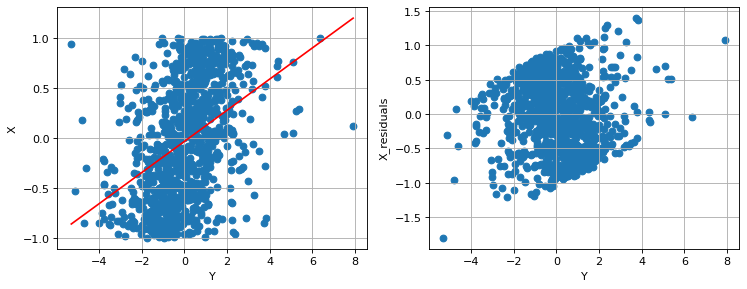





Case: (X,Epsilon) ~ CUBIC_UNIxGAU
function: Cubic
function: Linear


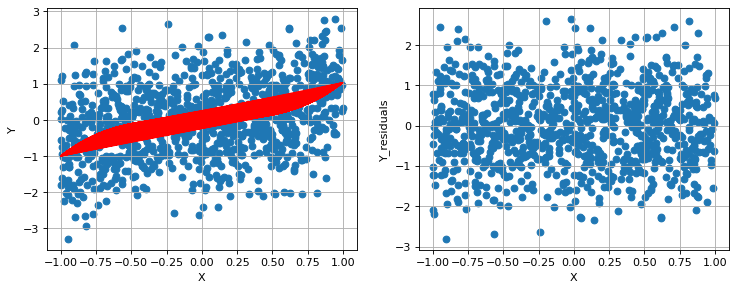

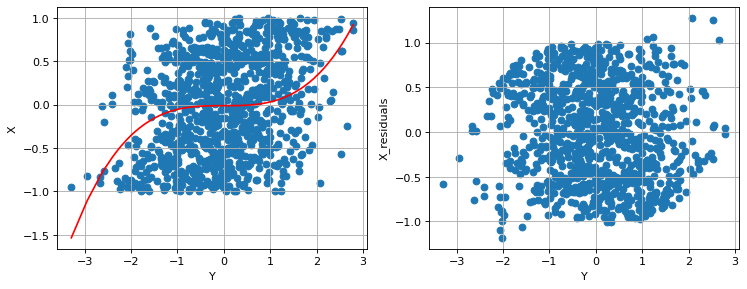





Case: (X,Epsilon) ~ CUBIC_UNIxLAP
function: Cubic
function: Linear


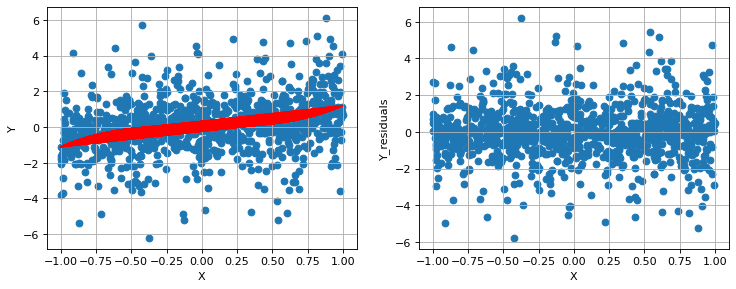

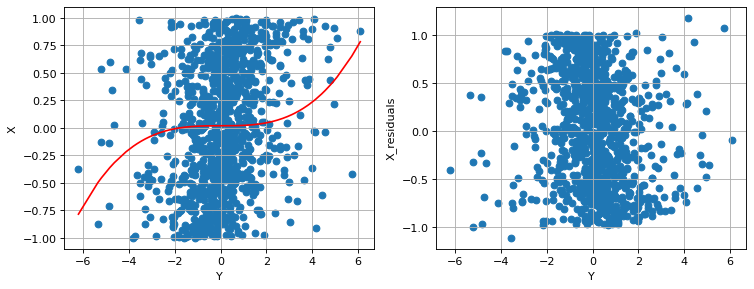





Case: (X,Epsilon) ~ QUAD_UNIxGAU
function: Quadratic
function: Linear


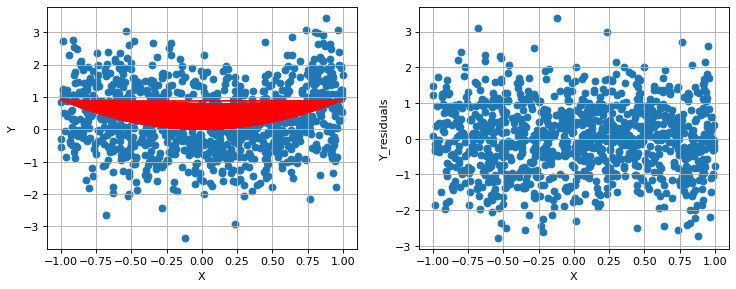

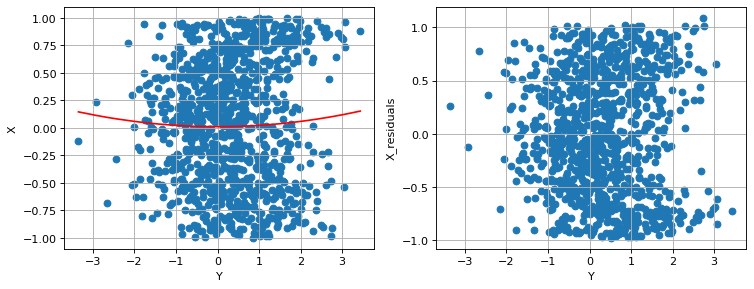





Case: (X,Epsilon) ~ QUAD_UNIxLAP
function: Quadratic
function: Linear


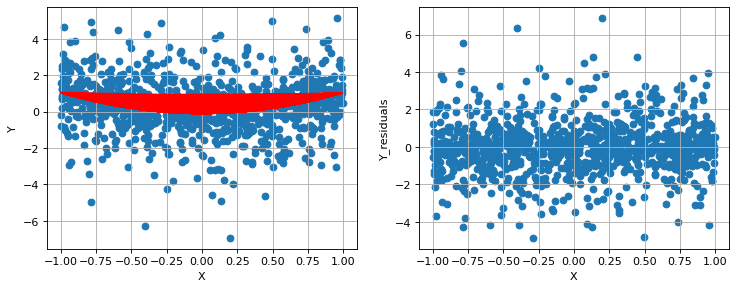

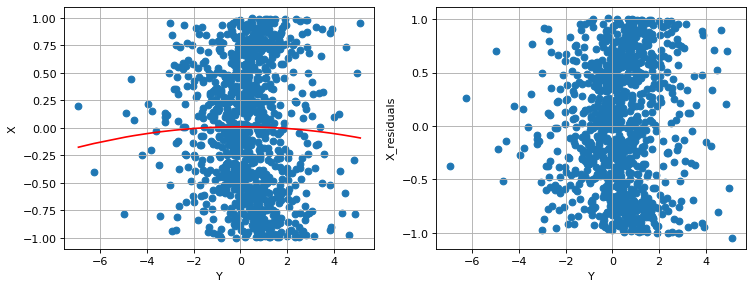





Case: (X,Epsilon) ~ SIN_UNIxGAU
function: Sinus


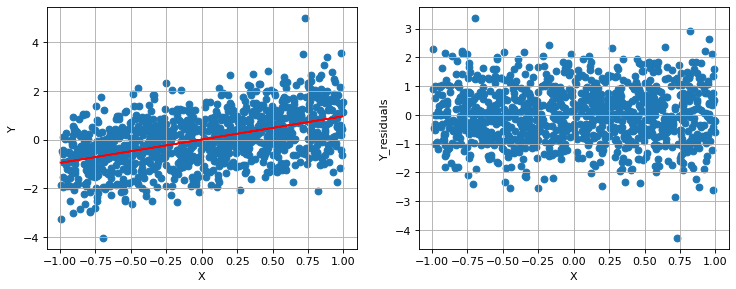

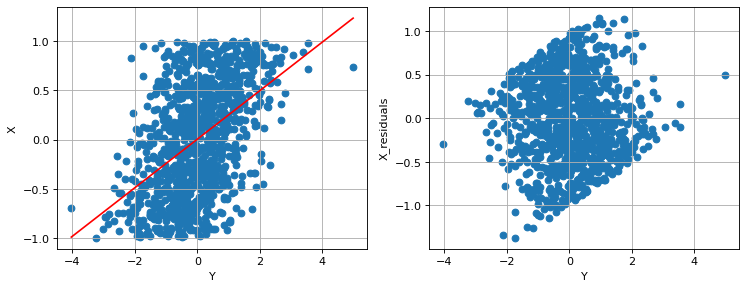





Case: (X,Epsilon) ~ SIN_UNIxLAP
function: Sinus


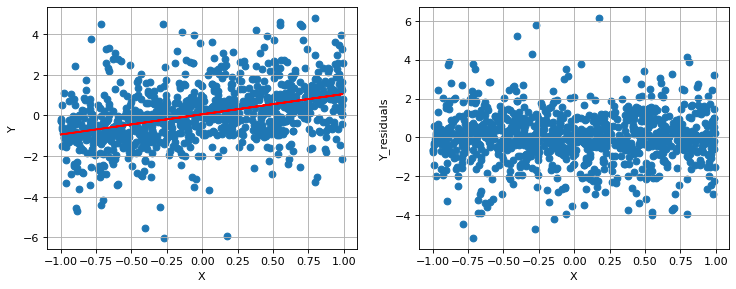

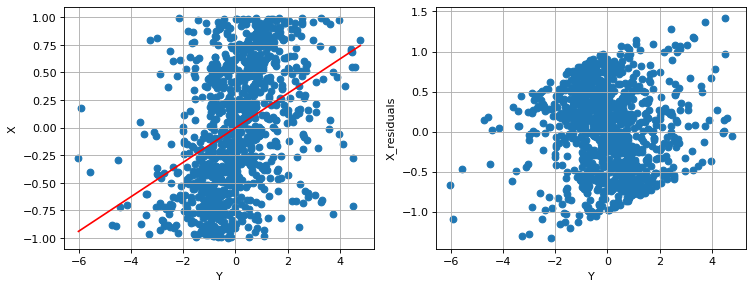





Case: (X,Epsilon) ~ LAPxGAU
function: Linear


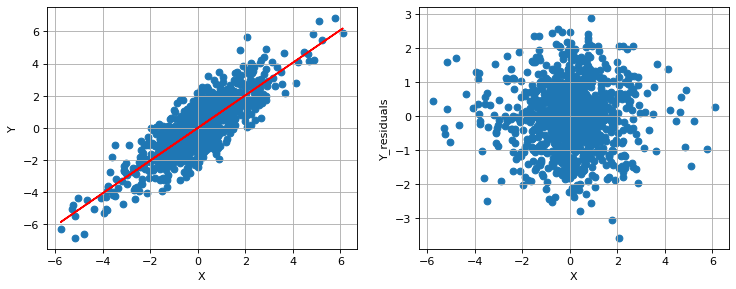

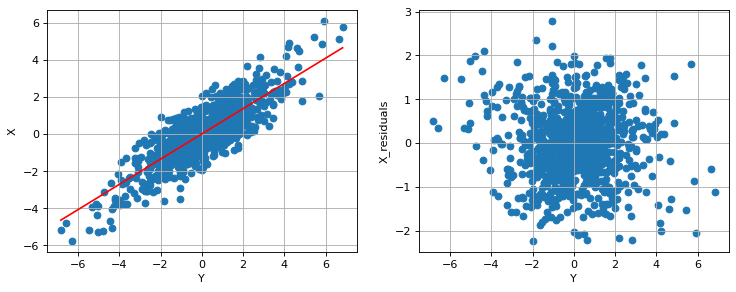





Case: (X,Epsilon) ~ LAPxUNI
function: Linear


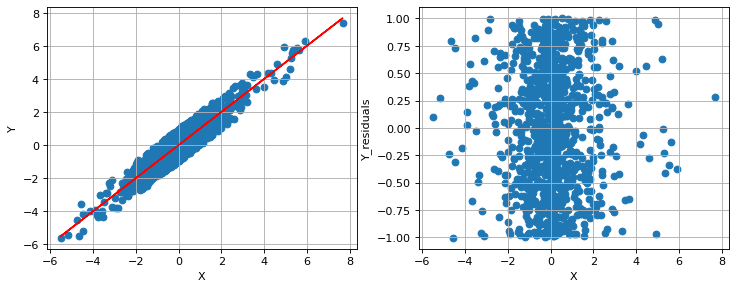

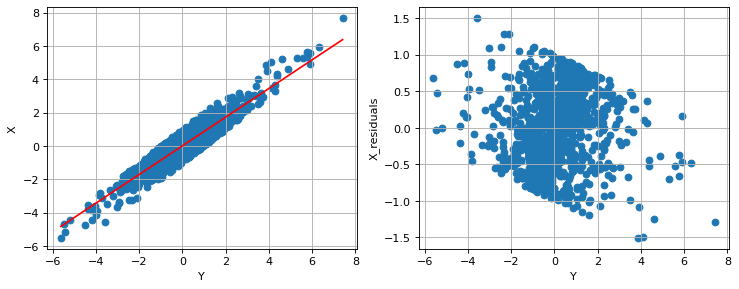





Case: (X,Epsilon) ~ CUBIC_LAPxGAU
function: Cubic
function: Linear


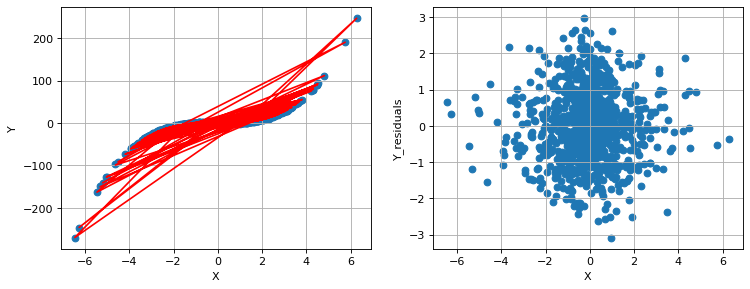

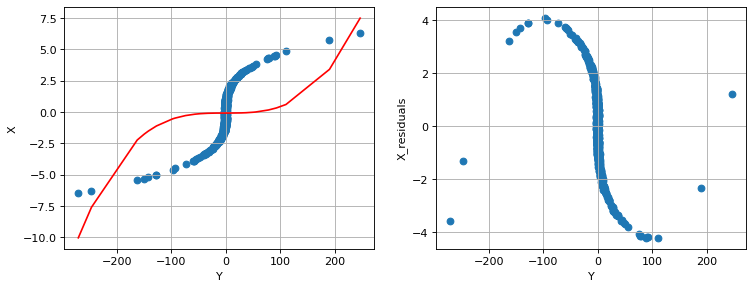





Case: (X,Epsilon) ~ CUBIC_LAPxUNI
function: Cubic
function: Linear


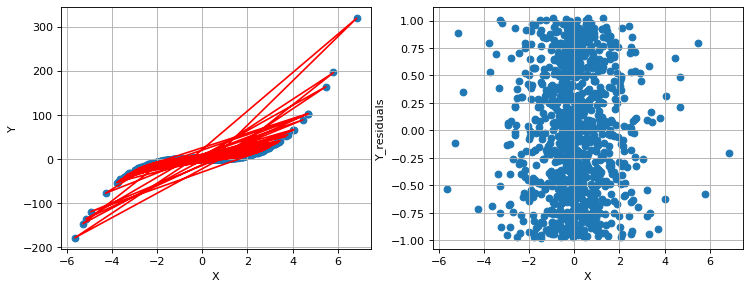

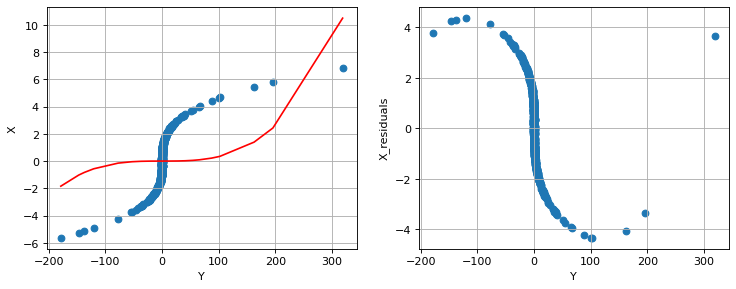





Case: (X,Epsilon) ~ QUAD_LAPxGAU
function: Quadratic
function: Linear


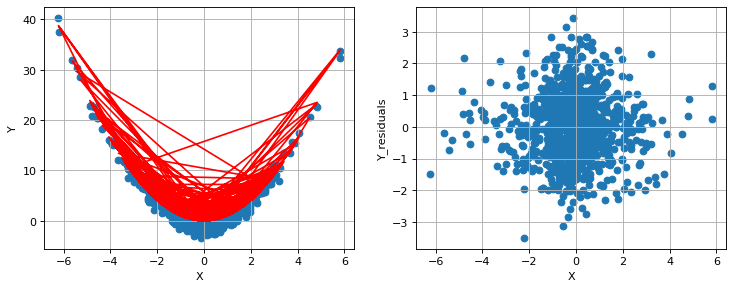

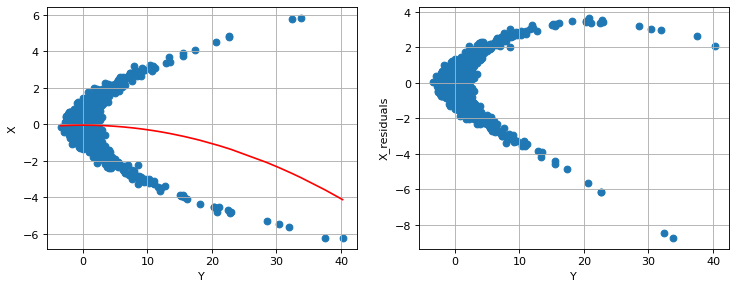





Case: (X,Epsilon) ~ QUAD_LAPxUNI
function: Quadratic
function: Linear


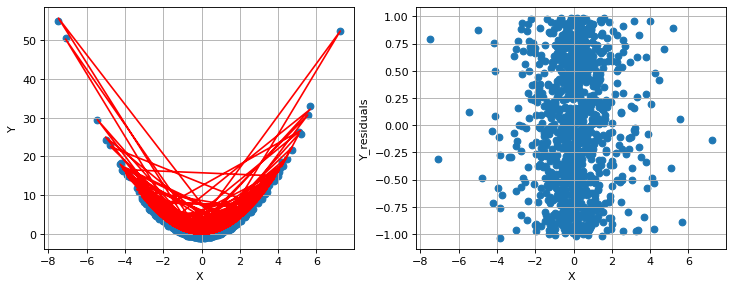

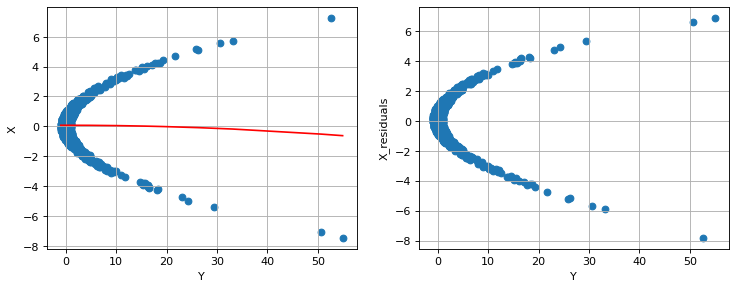





Case: (X,Epsilon) ~ SIN_LAPxGAU
function: Sinus


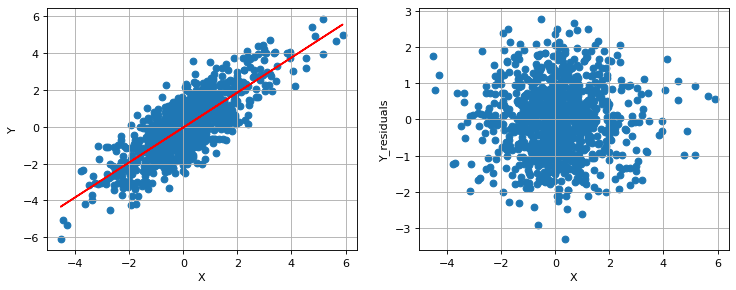

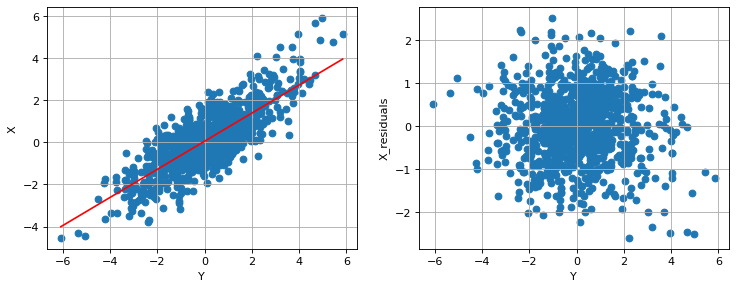





Case: (X,Epsilon) ~ SIN_LAPxUNI
function: Sinus


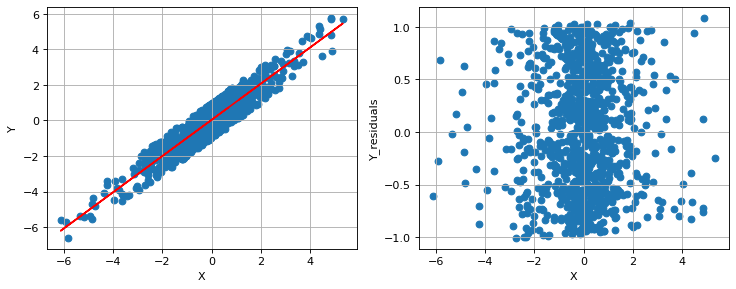

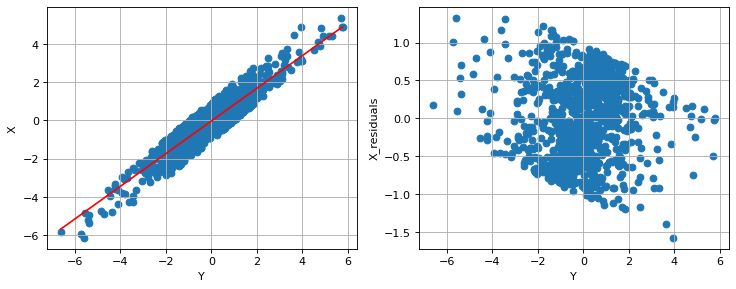

In [ ]:
for dist in dists:
  plotter(dist)

Case: (X,Epsilon) ~ UNIxGAU


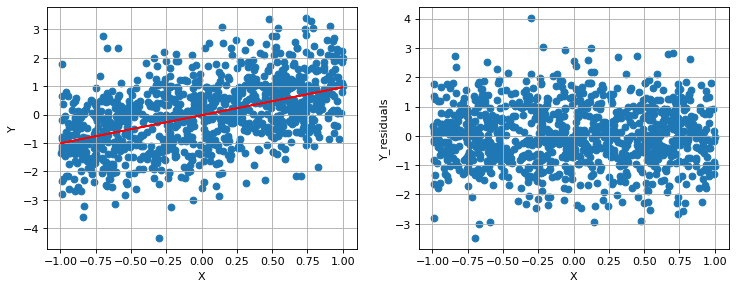

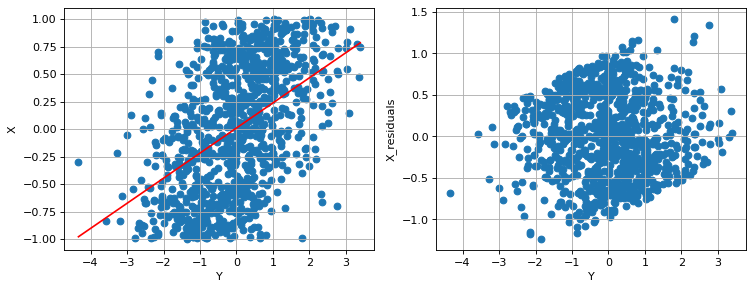

In [ ]:
plotter("UNIxGAU")

In [ ]:
def plotter_X_Y(dist):
    y, y_transformed, eps, x, x_pred = regress_X_Y_dict[dist] 
    
    # plotting
    figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.scatter(x=y, y=x)
    plt.plot(y, x_pred, color="red")
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X")

    # calculate the residuals and plot them
    x_residuals = x_pred - x
    plt.subplot(122)
    plt.scatter(x=y, y=x_residuals)
    plt.grid(True)
    plt.xlabel("Y")
    plt.ylabel("X_residuals")
    plt.show()

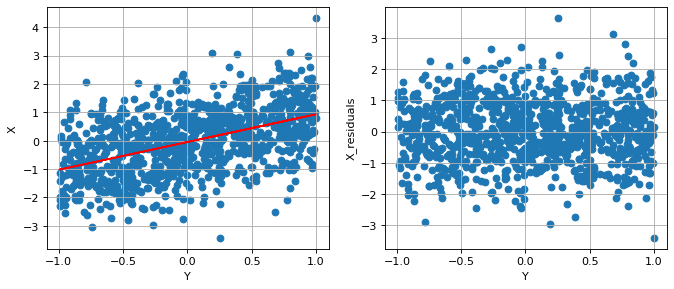

In [ ]:
plotter_X_Y("UNIxGAU")

# Post-Additive models

## Exercise 4

1. Perform the same test as in Excercise 3 for the following model: $Y=(f(X)+\epsilon)^3$, where the corresponding function $f(X)$ is specified [here](https://docs.google.com/spreadsheets/d/1aS87yTukUsMIJcLMMaeuVKnzVLkhhU7m3wKfNyN2I6E/edit?usp=sharing). 
2. What are your conclusions from all exercises in this notebook?